In [12]:
# Nvidia package for controlling memory usage
!pip install datasets accelerate nvidia-ml-py3

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets

In [14]:
# Load dataset
dataset_name = 'TIGER-Lab/MathInstruct'
dataset = datasets.load_dataset(dataset_name, split='train[:500]')

Show example of input and output

In [15]:
print('Instruction:', dataset['instruction'][0])
print('Answer:', dataset['output'][0])

Instruction: The distance between two stars is 6.52 × 10^5 light years. What is the distance between the two stars in parsecs? (1 parsec = 3.26 light years)
Answer Choices: (A) 2 × 10^5 (B) 4 × 10^6 (C) 5 × 10^7 (D) 7 × 10^7 (E) 9 × 10^8
Answer: Let's think about the multi-choice question.
6.52 × 10^5 ly / (3.26 ly/parsec) = 2 x 10^5 persec
The answer is A.


In [16]:
from pynvml import *


# Function for controlling GPU usage
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [17]:
# print_gpu_utilization()

In [18]:
model_checkpoint = 'h2oai/h2o-danube3-500m-base'

model = AutoModelForCausalLM.from_pretrained(model_checkpoint)


In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

In [20]:
# print_gpu_utilization()

In [23]:
def preprocess_function(example):
  return tokenizer(f"Instruction: {example['instruction']}, Answer: {example['output']}", max_length=150, padding=True, truncation=True)

In [24]:
tokenized_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset = tokenized_dataset.train_test_split()

In [26]:
tokenized_dataset = tokenized_dataset.remove_columns(['source', 'output', 'instruction'])

In [27]:
tokenized_dataset.set_format("torch")

In [28]:
from torch.utils.data import DataLoader
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
optimizer = AdamW(model.parameters(), 5e-5)

In [29]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-07-18 17:29:52.829499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 17:29:52.829558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 17:29:52.831729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [30]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 375
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 125
    })
})

In [31]:
batch_size = 1

In [32]:
train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=data_collator, shuffle=True)
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=data_collator)

In [48]:
from transformers import get_scheduler


num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)

learning_rate_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
print('Number of training steps:', num_training_steps)

In [49]:
from tqdm.autonotebook import tqdm

In [50]:
train_dataloader, eval_dataloader, model, optimizer = accelerator.prepare(train_dataloader, test_dataloader, model, optimizer)

progress_bar = tqdm(range(num_training_steps))

  0%|          | 0/11250 [00:00<?, ?it/s]

In [51]:
import torch

In [52]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")

In [53]:
model = torch.nn.DataParallel(model)

In [54]:
model.to(device)

DataParallel(
  (module): DataParallel(
    (module): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 1536, padding_idx=0)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): Linear(in_features=1536, out_features=1536, bias=False)
              (k_proj): Linear(in_features=1536, out_features=768, bias=False)
              (v_proj): Linear(in_features=1536, out_features=768, bias=False)
              (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=1536, out_features=4096, bias=False)
              (up_proj): Linear(in_features=1536, out_features=4096, bias=False)
              (down_proj): Linear(in_features=4096, out_features=1536, bias=False)
              (act_fn): SiLU()
            )
            (input

In [55]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)

    weighted_loss = loss_per_sample.mean()
    return weighted_loss

In [56]:
losses = []
model.train()
total_batches = len(train_dataloader)
for epoch in range(num_epochs):
  for i, batch in enumerate(train_dataloader):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    batch = {k: v.to(accelerator.device) for k,v in batch.items()}
    outputs = model(**batch)
    logits = outputs.logits
    loss = keytoken_weighted_loss(batch["input_ids"], logits)
    accelerator.backward(loss)

    optimizer.step()
    learning_rate_scheduler.step()
    progress_bar.update(1)
    print(f'Batch: {i}/{total_batches}, Loss: {loss}')
    losses.append(loss)

  print(f'Epoch: {epoch}, Loss: {loss}')





/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [57]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   7897 MiB |   9860 MiB |  74411 GiB |  74403 GiB |\n|       from large pool |   7877 MiB |   9840 MiB |  63750 GiB |  63742 GiB |\n|       from small pool |     20 MiB |    222 MiB |  10661 GiB |  10661 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   7897 MiB |   9860 MiB |  74411 GiB |  74403 GiB |\n|       from large pool |   7877 MiB |   9840 MiB |

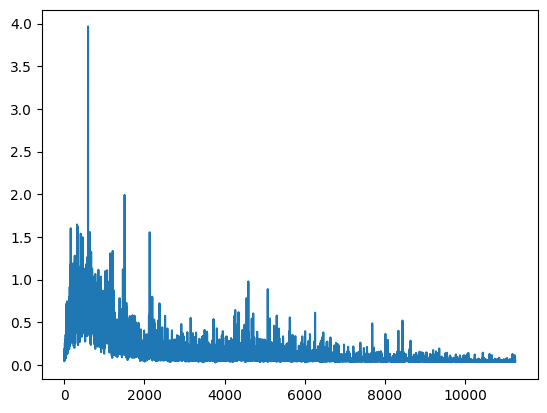

In [58]:
import matplotlib.pyplot as plt

losses = [loss.cpu().detach().numpy() for loss in losses]
plt.plot(losses)

In [59]:
from huggingface_hub import notebook_login

notebook_login()

In [60]:
model.module.push_to_hub("math-model")

AttributeError: 'DataParallel' object has no attribute 'push_to_hub'

In [ ]:
tokenizer.push_to_hub("math-tokenizer")

In [ ]:
dataset[0]